In [1]:
import harp
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import MultiPolygon
import harptools as ht
import glob
import os
import json
from tqdm import tqdm
from matplotlib.animation import ArtistAnimation
from IPython.display import display, HTML

from harptools import get_regrid_operations, get_water_geometry, create_tiles_random

In [2]:
#full orbits
ROOT = '../../DATA/'
spatial_extent = [14, 33.2, 19.3, 38] # mediterranean sea area
# Open aoi.json
with open(f"{ROOT}aoi.json", "r") as f:
    aoi = json.load(f)

Area of interest is a list, converting to a box


C:\Users\ruben\AppData\Local\Temp\ipykernel_21596\1005940821.py:48: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


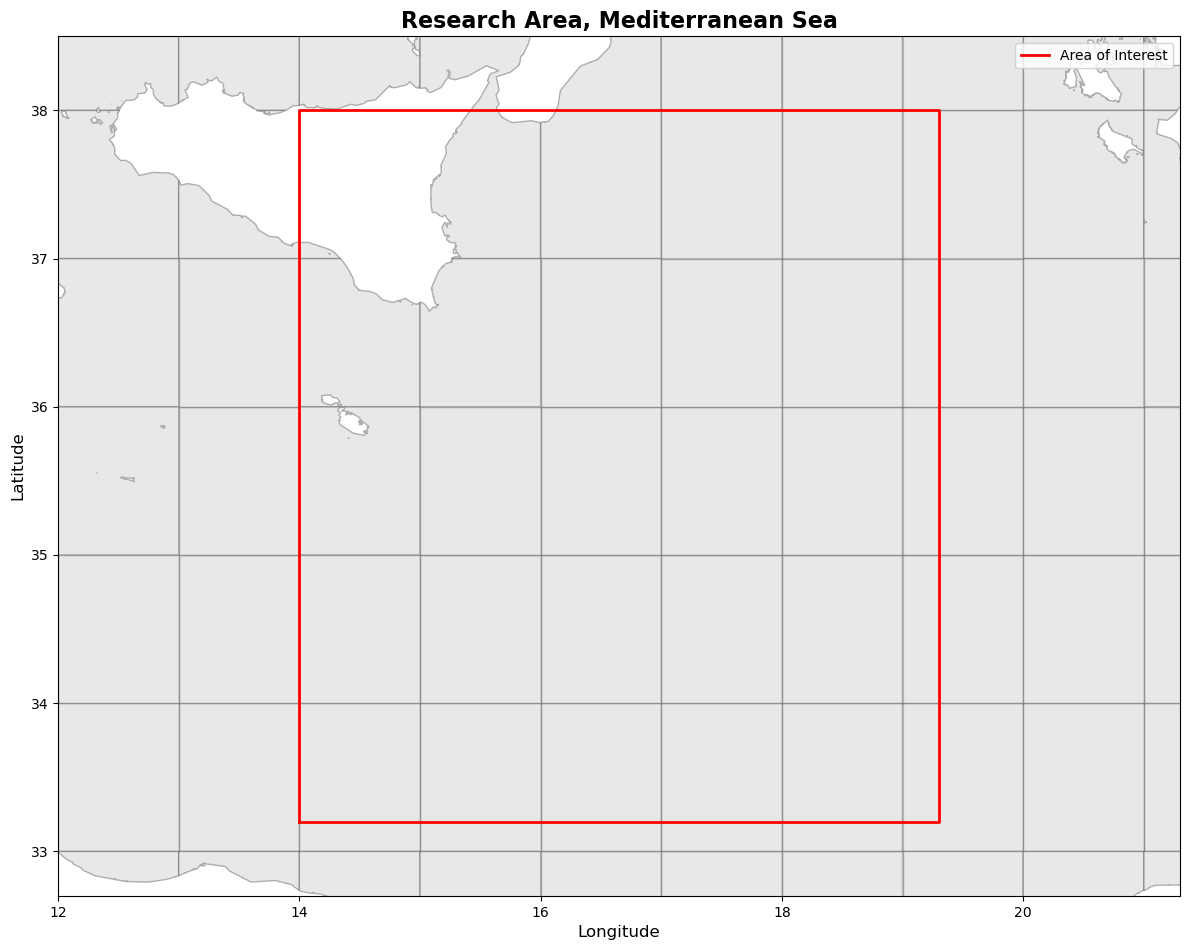

In [3]:
# Assuming you have already imported necessary libraries and defined your functions

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import box


# Load geometry from file
# incorporate margin around the AOI for better visualization
water_extent = [spatial_extent[0] - 2, spatial_extent[1] - 0.5, spatial_extent[2] + 2, spatial_extent[3] + 0.5]

polygon = get_water_geometry(water_extent, ROOT, simplify=False)
sea_polygon = polygon

# Create a GeoDataFrame for the simplified multipolygon
crs_code = "EPSG:4326"
gdf_simple = gpd.GeoDataFrame({'geometry': [polygon]}, crs=crs_code)  # Update CRS if needed


# Initialize the plot with a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted figsize for better visibility

# Plot simplified multipolygon (AOI) on the axes
gdf_simple.plot(color='#D3D3D3', edgecolor='#696969', alpha=0.5, ax=ax, label='Area of Interest')  # Light Gray

# plot area of interest (spatial_extent)
lon_min, lat_min, lon_max, lat_max = spatial_extent
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='red', label='Area of Interest', linewidth=2)  # Red


# **Set plot limits to crop to the AOI**
lon_min, lat_min, lon_max, lat_max = water_extent
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Optional: Ensure the aspect ratio is equal for accurate geographic representation
# ax.set_aspect('equal')

# Set plot titles and labels
ax.set_title('Research Area, Mediterranean Sea', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Adjust legend to the bottom left with a clean layout
plt.legend()

# Adjust layout to make room for the legend and titles
plt.tight_layout()

# Save and show the figure
plt.savefig('../../Figures/aoi_no_plumes.pdf', bbox_inches='tight')  # Saved as PNG for better quality
plt.show()


# random tiles

Area of interest is a list, converting to a box


C:\Users\ruben\AppData\Local\Temp\ipykernel_21596\917279765.py:89: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()
C:\Users\ruben\AppData\Local\Temp\ipykernel_21596\917279765.py:122: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend()


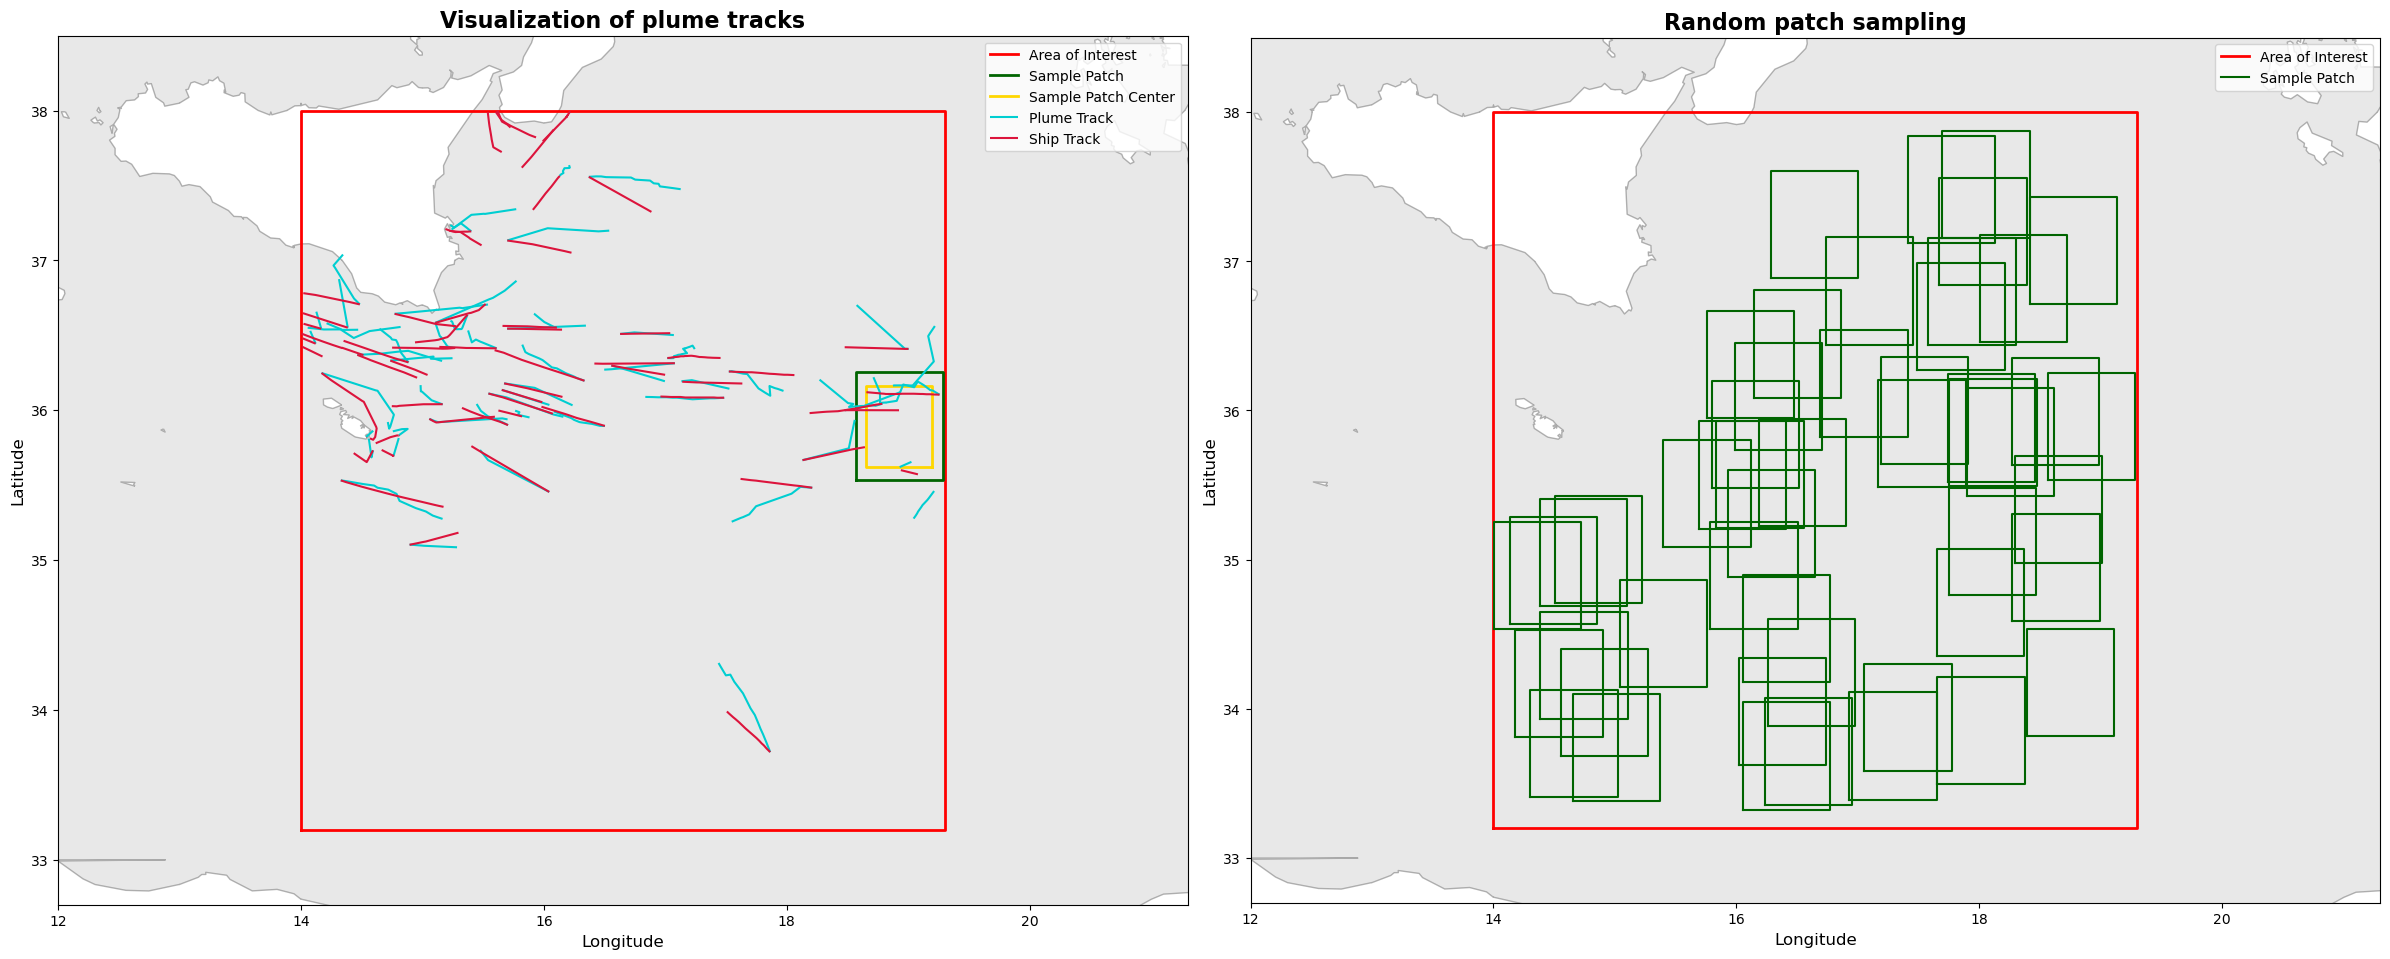

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import box

# Load geometry from file
water_extent = [spatial_extent[0] - 2, spatial_extent[1] - 0.5, spatial_extent[2] + 2, spatial_extent[3] + 0.5]

polygon = get_water_geometry(water_extent, ROOT)
sea_polygon = polygon

# Create a GeoDataFrame for the simplified multipolygon
crs_code = "EPSG:4326"
gdf_simple = gpd.GeoDataFrame({'geometry': [polygon]}, crs=crs_code)

# Create tiles
tiles, tile_centers, _ = create_tiles_random(spatial_extent, ocean=sea_polygon)

# Initialize the plot with a figure and two axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))  # Adjusted figsize for better visibility

# --- Plot 1: Research Area, Mediterranean Sea --- #

# Plot simplified multipolygon (AOI) on the first axes
gdf_simple.plot(color='#D3D3D3', edgecolor='#696969', alpha=0.5, ax=ax1, label='Area of Interest')

# Plot Area of Interest (spatial_extent)
lon_min, lat_min, lon_max, lat_max = spatial_extent
ax1.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
         [lat_min, lat_min, lat_max, lat_max, lat_min],
         color='red', label='Area of Interest', linewidth=2)

# Plot Sample Patch on the first axes
tile = tiles[0]
tile_center = tile_centers[0]
lon_min_tile, lat_min_tile, lon_max_tile, lat_max_tile = tile

ax1.plot([lon_min_tile, lon_max_tile, lon_max_tile, lon_min_tile, lon_min_tile],
         [lat_min_tile, lat_min_tile, lat_max_tile, lat_max_tile, lat_min_tile],
         color='#006400', label='Sample Patch', linewidth=2)

# Plot the tile center polygon on the same axes
ax1.plot(*tile_center.exterior.xy, color='#FFD700', label='Sample Patch Center', linewidth=2)

# Load the AIS data
ais_file = f"{ROOT}AIS/AIS_processed/Mediterranean/2021/01/03/AIS.csv"
ais = gpd.read_file(ais_file)

# Convert WKT strings to geometries for plume_track and ship_track
ais[['plume_track', 'ship_track']] = ais[['plume_track', 'ship_track']].apply(gpd.GeoSeries.from_wkt)

# Create separate GeoDataFrames for plume and ship tracks
ais_plume = ais.set_geometry('plume_track').copy()
ais_ship = ais.set_geometry('ship_track').copy()

# Set the CRS for AIS GeoDataFrames
ais_plume.set_crs(crs_code, inplace=True)
ais_ship.set_crs(crs_code, inplace=True)

# Ensure both AIS GeoDataFrames have the same CRS as the AOI
ais_plume = ais_plume.to_crs(gdf_simple.crs)
ais_ship = ais_ship.to_crs(gdf_simple.crs)

# Create a bounding box for the AOI
aoi_bbox = box(lon_min, lat_min, lon_max, lat_max)

# Filter AIS plume tracks within the AOI
ais_plume_filtered = ais_plume[ais_plume.within(aoi_bbox)]

# Filter AIS ship tracks within the AOI
ais_ship_filtered = ais_ship[ais_ship.within(aoi_bbox)]

# Plot the filtered AIS plume tracks on the first axes
ais_plume_filtered.plot(color='#00CED1', label='Plume Track', ax=ax1, markersize=10)

# Plot the filtered AIS ship tracks on the first axes
ais_ship_filtered.plot(color='#DC143C', label='Ship Track', ax=ax1, markersize=10)

# Set plot limits to crop to the AOI
ax1.set_xlim(water_extent[0], water_extent[2])
ax1.set_ylim(water_extent[1], water_extent[3])

# Set plot titles and labels for the first plot
ax1.set_title('Visualization of plume tracks', fontsize=16, fontweight='bold')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)

# Adjust legend for the first plot
ax1.legend()

# --- Plot 2: AOI and Tiles with Coastline --- #

# Plot simplified multipolygon (Coastline) on the second axes
gdf_simple.plot(color='#D3D3D3', edgecolor='#696969', alpha=0.5, ax=ax2, label='Coastline')

# Function to plot rectangles
def plot_rectangle(ax, coords, color, label=None, linewidth=2):
    lon_min, lat_min, lon_max, lat_max = coords
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
            [lat_min, lat_min, lat_max, lat_max, lat_min],
            color=color, label=label if label else None, linewidth=linewidth)

# Plot Area of Interest (AOI) on the second axes
plot_rectangle(ax2, spatial_extent, color='red', label='Area of Interest')

# Plot all tiles on the second axes, only label the first tile
tile_label_shown = False
for tile in tiles:
    plot_rectangle(ax2, tile, color='#006400', label='Sample Patch' if not tile_label_shown else None, linewidth=1.5)
    tile_label_shown = True

# Set plot limits to crop to the AOI
ax2.set_xlim(water_extent[0], water_extent[2])
ax2.set_ylim(water_extent[1], water_extent[3])

# Set plot titles and labels for the second plot
ax2.set_title('Random patch sampling', fontsize=16, fontweight='bold')
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)

# Adjust legend for the second plot
ax2.legend()

# Adjust layout to make room for the legends and titles
fig.tight_layout()

# Save and show the combined figure
plt.savefig('../../Figures/combined_aoi_tiles.pdf', bbox_inches='tight')
plt.show()

In [5]:
def harp_l2geoscatterplot(product, value, colorrange=None, colortable='jet'):
    variable = product[value]
    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.scatter(product.longitude.data, product.latitude.data, c=variable.data, 
                      vmin=vmin, vmax=vmax, cmap=colortable, s=1, transform=ccrs.PlateCarree())

    ax.coastlines()
    # ax.set_extent(spatial_extent)

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()

In [6]:
def harp_l3meshplot(product, variable, colorrange=None, colortable='jet', title=None):
    variable = product[variable]
    gridlat = np.append(product.latitude_bounds.data[:,0], product.latitude_bounds.data[-1,1])
    gridlon = np.append(product.longitude_bounds.data[:,0], product.longitude_bounds.data[-1,1])
    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(gridlon, gridlat, variable.data[0,:,:], vmin=vmin, vmax=vmax,
                         cmap=colortable, transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.gridlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.title(title)
    plt.show()

`lat_resolution = lon_resolution = 0.003  # takes 18 seconds`

`lat_resolution = lon_resolution = 0.004  # takes 6 seconds`

`lat_resolution = lon_resolution = 0.005  # takes 3 seconds`

The sampling resolution has a complexity of $O(N^2)$. For this AOI, $0.005$ is optimal

`area_covers_area` is slow AF

In [7]:
def simple_operations(spatial_extent: list, filter_vars: bool = False) -> str:
    """
    Returns a string of operations to be used in the harp.import_product function
    This function needs to be changed if a user wants to use different operations or products.
    The product names in harp are different from the product names in the S5P data. And need to be changed manually to ensure accuracy.
    # product names: https://stcorp.github.io/harp/doc/html/ingestions/index.html#sentinel-5p-products
    """
    lon_min, lat_min, lon_max, lat_max = spatial_extent
    variables = {
    "HCHO": ["HCHO_slant_column_number_density", "tropospheric_HCHO_column_number_density_validity"],
    "NO2": ["NO2_slant_column_number_density", "tropospheric_NO2_column_number_density_validity"],
    "SO2": ["SO2_slant_column_number_density", "SO2_column_number_density_validity"],
    "misc": ["datetime_start", "datetime_length", "latitude", "longitude", "cloud_fraction", 
             "surface_meridional_wind_velocity", "surface_zonal_wind_velocity", "latitude_bounds", "longitude_bounds",
             "solar_zenith_angle", "sensor_zenith_angle", "solar_azimuth_angle", "sensor_azimuth_angle"],
    }
    
    ops = [f"latitude>={lat_min}",f"latitude<={lat_max}",f"longitude>={lon_min}",f"longitude<={lon_max}"]
    
    if filter_vars:
        ops.append(f"keep({','.join(variables['HCHO']+variables['NO2']+variables['SO2']+variables['misc'])})")
    
    operations = ";".join(ops)
    return operations

# Animate regridded tropomi files

In [8]:
from shapely import points as shp_points
def mask_coordinates(path: str, array_to_mask: np.array, tropomi_data: harp.Product, polygon, area_of_interest: list) -> np.array:
    """
    Masks the data based on the given polygon.
    
    Args:
        path: The path to the file where the mask will be saved, ends with a '/'
        array_to_mask: The data to be masked, 
        pointsgrid: The coordinates of the data, (latitude, longitude, (longitude_coords, latitude_coords))
        polygon: Shapely polygon to be used for masking, in this case, the water in the area of interest
        area_of_interest: The area of interest in the form [lon_min, lat_min, lon_max, lat_max]

    Returns:
        The masked data
    """

    # check if mask exists as a file
    filename = path+'Mask_files/mask_' + "_".join([str(x) for x in area_of_interest]) + '.npy'
    if os.path.exists(filename):
        mask = np.load(filename)
    else:    
        # mask the data with the tile polygon
        lon_grid, lat_grid = np.meshgrid(tropomi_data.longitude.data, tropomi_data.latitude.data)
        # turn lon_grid and lat_grid into an array with shape (n*m,2)
        points = np.array([lon_grid.flatten(), lat_grid.flatten()]).T

        # Check if each point is inside the polygon, remember that the first point is the longitude and the second the latitude
        mask_flat = polygon.contains(shp_points(coords=points))
        mask = mask_flat.reshape(lon_grid.shape)
        # Save the mask to a file
        if not os.path.exists(path+'Mask_files'):
            os.makedirs(path+'Mask_files')
        np.save(filename, mask)

    # # Apply the mask to the data
    # plt.clf()
    # plt.imshow(lat_grid)
    # plt.colorbar()
    # plt.show()
    return np.where(mask, array_to_mask, np.nan)


def process_tropomi_data(aoi, start_idx=1000, end_idx=1020, save_video=True, save_frames=False, output_dir="NO2_frames", format='pdf'):
    """
    Process TROPOMI data and either save as a video or save all frames in a folder.

    Parameters:
    - aoi (dict): Dictionary of area of interest with name as key and bounding box as value.
    - ROOT (str): The root directory containing the TROPOMI data.
    - start_idx (int): The start index for the files to be processed.
    - end_idx (int): The end index for the files to be processed.
    - save_video (bool): Whether to save the output as a video.
    - save_frames (bool): Whether to save each frame as an image in a folder.
    - output_dir (str): Directory where frames will be saved if save_frames is True.
    """
    plt.ioff()


    # Create a directory to store the PNG files if needed
    if save_frames:
        os.makedirs(output_dir, exist_ok=True)

    for aoi_name, area_of_interest in aoi.items():
        sea_polygon = get_water_geometry(area_of_interest, ROOT, simplify=True)
        regrid_operations, reduce_operations = get_regrid_operations(area_of_interest)
        files = glob.glob(f"{ROOT}TinyEODATA/{aoi_name}/Sentinel-5P/TROPOMI/L3__Merged_/*/*/*/*.nc")
        
        NO2_regridded = []
        for i, file in enumerate(tqdm(files[start_idx:end_idx])):
            fig, ax = plt.subplots()
            regrid_tropomi_data = harp.import_product(file, operations=regrid_operations, reduce_operations=reduce_operations)

            # mask image based on land area
            no2_data = regrid_tropomi_data.NO2_slant_column_number_density.data[0]
            no2_data = mask_coordinates(ROOT, no2_data, regrid_tropomi_data, sea_polygon, area_of_interest)

            plot = ax.imshow(no2_data, origin='lower', vmin=0, vmax=1.5e16)
            # plot = ax.imshow(no2_data, origin='lower')
            
            date_str = file.split("\\")[-4:-1]
            date_str = f'{date_str[0]}-{date_str[1]}-{date_str[2]}'
            
            fig.colorbar(plot, ax=ax, label='NO2 Slant Column Density (molec/cm2)')
            ax.set_title(f'{aoi_name} {date_str}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_xticks([0, no2_data.shape[1]-1])
            ax.set_xticklabels([area_of_interest[0], area_of_interest[2]])
            ax.set_yticks([0, no2_data.shape[0]-1])
            ax.set_yticklabels([area_of_interest[3], area_of_interest[1]])
            
            # Save the current frame as a PNG file in the output directory if requested
            if save_frames:
                png_filename = os.path.join(output_dir, f"frame_{i:04d}.{format}")
                fig.savefig(png_filename, format=format)
            
            # Add the plot to the animation list if saving video
            if save_video:
                NO2_regridded.append([plot])
            
            # Clear the axes for the next frame
            ax.clear()
            plt.close(fig)
        
        # Save the video if requested
        if save_video:
            ani = ArtistAnimation(fig=fig, artists=NO2_regridded, interval=500, blit=True, repeat_delay=500)
            ani.save(f'{aoi_name}_NO2_regridded.mp4', writer='ffmpeg')
        
        # Break after the first AOI; remove this to process all AOIs
        break  

    plt.close(fig)


In [9]:
process_tropomi_data(aoi, save_video=True, save_frames=True)


Area of interest is a list, converting to a box


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


AttributeError: 'NoneType' object has no attribute 'canvas'